In [32]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras, open in bathymetry_env
"""

# imports 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import osr
import gdal
import os
import leafmap
import math
import geojson
import datetime
import time
import rasterio

from tqdm.notebook import tqdm_notebook
from dateutil.relativedelta import relativedelta
from geojson import Feature, FeatureCollection, dump
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from scipy import stats, interpolate
from google.cloud import storage

# coordinate conversions
SR4326 = osr.SpatialReference()
SR4326.ImportFromEPSG(4326)     # WGS84 / Geographic
SR3857 = osr.SpatialReference()
SR3857.ImportFromEPSG(3857)     # WGS84 / Pseudo-Mercator
ct_4326_to_3857 = osr.CoordinateTransformation(SR4326, SR3857)
ct_3857_to_4326 = osr.CoordinateTransformation(SR3857, SR4326)

# Project specific toggles

In [10]:
# see scheme at acces_api.pdf for a workflow visualization

# project toggles
file_fol = r'p:\satellite-derived-bathymetry' # name of the local folder for the input data
bucket = 'jip_calm_sdb' # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r'p:\11204209-jip-calm\WT4.1_SDB\GEE_images\jip-calm-c1886b3313b9.json' # Cloud Storage credential key
overall_project = 'RWS_SDB' # name of the overall project
project_name = 'Friese_Zeegat' # name of the project AoI
draw_tr = 0 # toggle 1 to draw transect(s), 0 to load

# composite image toggles 
scale = 19.109  # output resolution of the image [m]

# Loading pre-processed files (API)

In [78]:
# authentication
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_file

# get file names
client = storage.Client()
ls = [blob for blob in client.list_blobs(bucket)] 
ProcessedList = [str(blob).split(',')[1][1:] for blob in ls if project_name in str(blob).split(',')[1][1:]] 
            
# get data from Google Cloud Storage
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for file in tqdm_notebook(ProcessedList):
    with rasterio.Env(GS_ACCESS_KEY_ID=credential_file):
        tiles.append(gdal.Open(r"https://storage.googleapis.com/{}/{}".format(bucket, file)))
        tile_paths.append(r"https://storage.googleapis.com/{}/{}".format(bucket, file))
        tile_names.append(file.split('/')[-1])
        tile_times.append(file.split('.')[0].split('_')[-2] + ' - ' + file.split('.')[0].split('_')[-1])
        time.sleep(0.01)

  0%|          | 0/16 [00:00<?, ?it/s]

In [80]:
# get data from local drive
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for root, dirs, files in os.walk(os.path.join(file_fol, overall_project, project_name)):
    if len(files) > 0: # access main folder files
        for file in tqdm_notebook(files):
            if 'xml' not in file: 
                tiles.append(gdal.Open(os.path.join(file_fol, overall_project, project_name, file)))
                tile_paths.append(os.path.join(file_fol, overall_project, project_name, file))
                tile_names.append(file)
                tile_times.append(file.split('.')[0].split('_')[-2] + ' - ' + file.split('.')[0].split('_')[-1])
                time.sleep(0.01)

  0%|          | 0/16 [00:00<?, ?it/s]

# Visualization / Use-case (interactive)

In [12]:
# open AoI
with open(os.path.join(os.getcwd(),'RWS_AOI',project_name+'.geojson')) as f:
    AoIjson = geojson.load(f)

AoI = Polygon(AoIjson['features'][0]['geometry']['coordinates'][0]) 

# initialize map
Map = leafmap.Map(center=[AoI.centroid.xy[1][0], AoI.centroid.xy[0][0]], zoom=11) 
Map.add_basemap(basemap='ROADMAP')

# add first composite to show as base layer
Map.add_local_tile(tile_paths[0], palette='colorbrewer.sequential.Blues_8_r', layer_name='Composite %s'%tile_times[0])
#Map.add_raster(tile_paths[0], colormap='Blues_r', layer_name='Composite %s'%tile_times[0])

# add AoI
style = {'fillOpacity':0.01}
hover_style = {'fillOpacity':0.05}
Map.add_geojson(AoIjson, layer_name='AoI', style=style, hover_style=hover_style)

if draw_tr == 1:
    print('Please draw transect(s) at interesting feature(s) of at most 2 points') # identifier
if draw_tr == 0:
    # open transects
    print('Loading and visualizing transect(s) of at most 2 points') #identifier
    for root, dirs, files in os.walk(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects')):
        for file in files:
            if '.geojson' in file:
                Map.add_geojson(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects',file), layer_name='transect %s'%file.split('.')[0].split('_')[1])

# show map
Map

Loading and visualizing transect(s) of at most 2 points


Map(center=[53.466505999999995, 6.041828], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

In [7]:
# construct the AoI if polygon is drawn in cell above

if draw_tr == 1:
    
    print('Constructing transect(s) from drawn line(s)') # identifier
    
    # get transects
    trs = [] # create transect shapefile(s)
    for i in Map.draw_features:
        conv_coords = []
        for coords in i['geometry']['coordinates']:
            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
            conv_coords.append([mapxg, mapyg])
        trs.append(LineString(conv_coords))

    # export transects
    for idx, (i, j) in enumerate(zip(trs, Map.draw_features)):
        
        # use EPSG4326 for the geojson (to show on the map)
        features = []
        features.append(Feature(geometry=LineString(j['geometry']['coordinates']), properties={"transect": idx+1}))
        crs = {"type": "name","properties": {"name": "EPSG:4326"}}
        feature_collection = FeatureCollection(features, crs=crs)
        with open(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects','transect_%s_4326'%(idx+1)+'.geojson'), 'w') as f: # geojson
            dump(feature_collection, f)
            
        # use EPSG3857 for the shapefile
        gdr = gpd.GeoDataFrame({'properties':['transect %s'%(idx+1)], 'geometry': [i]}, crs='EPSG:3857') #shp
        gdr.to_file(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects','transect_%s_3857'%(idx+1)+'.shp'))
    
if draw_tr == 0:
    print('Reconstructing transect(s) from loaded file(s)')
    # get transects
    trs = []
    for root, dirs, files in os.walk(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects')):
        for file in files:
            if '.geojson' in file:
                with open(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects',file)) as f:
                    trs_file = geojson.load(f)
                    try: # drawn polygon in this script
                        conv_coords = []
                        for coords in trs_file['features'][0]['geometry']['coordinates']:
                            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
                            conv_coords.append([mapxg, mapyg])
                        trs.append(LineString(conv_coords))
                    except: # drawn in QGIS / ArcGIS and written to geojson there (client file) (Note, has to be EPSG4326)
                        conv_coords = []
                        for coords in trs_file['features'][0]['geometry']['coordinates'][0]:
                            mapxg, mapyg, _ = ct_4326_to_3857.TransformPoint(coords[1], coords[0])
                            conv_coords.append([mapxg, mapyg])
                        trs.append(LineString(conv_coords))

Reconstructing transect(s) from loaded file(s)


In [8]:
# calculate elevation along drawn / loaded transect(s)

# get raster values for multiple bands
def raster_values(x,y,layer,bands,gt):
    col=[]
    px = int((x - gt[0]) / gt[1])
    py =int((y - gt[3]) / gt[5])
    for j in range(bands):
        band = layer.GetRasterBand(j+1)
        data = band.ReadAsArray(px,py, 1, 1)
        col.append(data[0][0])
    return col

# get values along a transect
tx = []
ty = []
tzg = []
tmask = []
td = []
td_corr = []
for tr in trs:
    x = []
    y = []
    zg = []
    mask = []
    d = []
    d_corr = []
    for composite in tiles:
        # composite characteristics
        gt = composite.GetGeoTransform()
        bands = composite.RasterCount
        
        # filtering values
        length=tr.length # in m 
        
        # correct transect length and scale (EPSG:3857 is distorted away from the equator, i.e. at higher latitudes)
        start_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][0], tr.coords.xy[1][0]) # start latitude
        end_coord = ct_3857_to_4326.TransformPoint(tr.coords.xy[0][1], tr.coords.xy[1][1]) # end latitude
        length_corr = length*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction(short distances)
        scale_corr = scale*np.cos(np.radians(np.mean([start_coord[0], end_coord[0]]))) # easy correction (short distances)
    
        xs = []
        ys = []
        zgs = []
        masks = []
        ds = []
        ds_corr = []
        for currentdistance, corrdistance in zip(np.arange(0,length,scale), np.arange(0,length_corr,scale_corr)):
            point = tr.interpolate(currentdistance) 
            xp,yp=point.x, point.y
            xs.append(xp), ys.append(yp) # appending
            # append the elevations, ignoring the red and blue band outcomes
            zgs.append(raster_values(xp,yp,composite, bands,gt)[1]) # green
            masks.append(raster_values(xp,yp,composite, bands,gt)[3]<=0) # watermask, smaller than zero --> land
            ds.append(currentdistance)
            ds_corr.append(corrdistance) # only used here, not for finding values as .tif is not corrected
        zgcorr = np.array(zgs)
        zgcorr[np.array(masks)] = np.nan # mask uit trues (land)
        
        # appending
        x.append(np.array(xs))
        y.append(np.array(ys))
        zg.append(zgcorr)
        mask.append(np.array(masks))
        d.append(np.array(ds))
        d_corr.append(np.array(ds_corr))
        
    # appending
    tx.append(x)
    ty.append(y)
    tzg.append(zg)
    tmask.append(mask)
    td.append(d)   
    td_corr.append(d_corr)

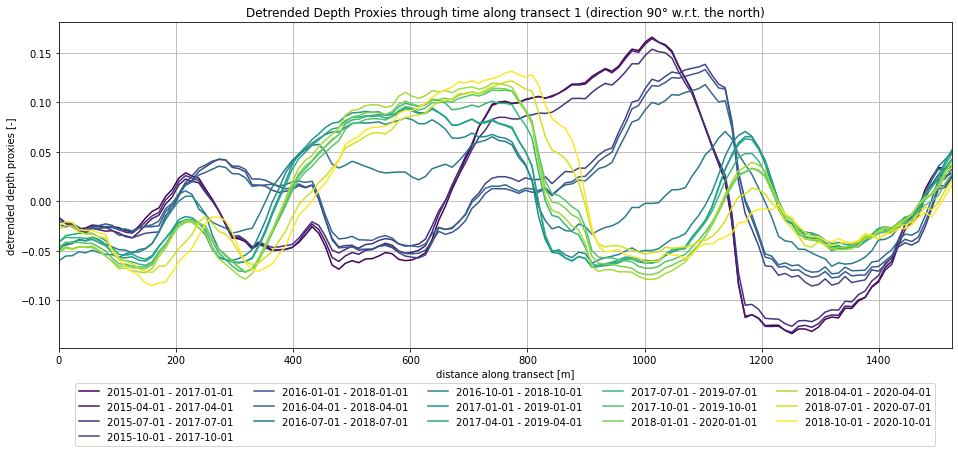

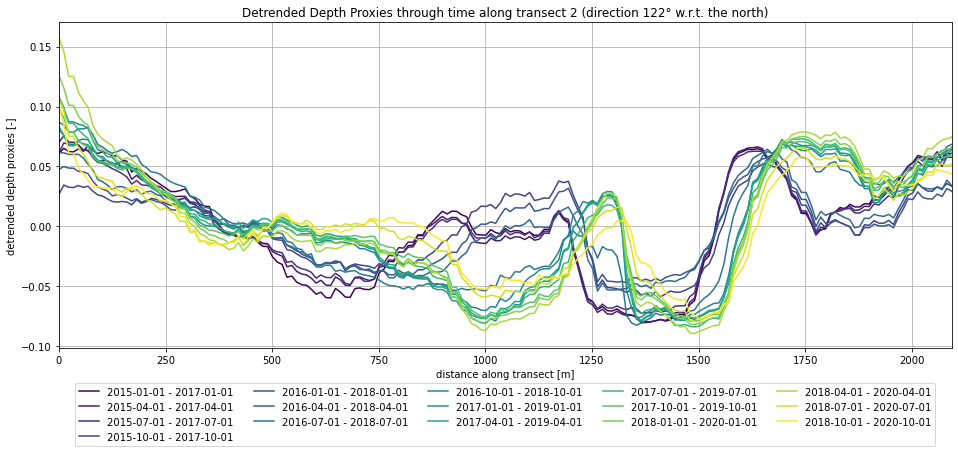

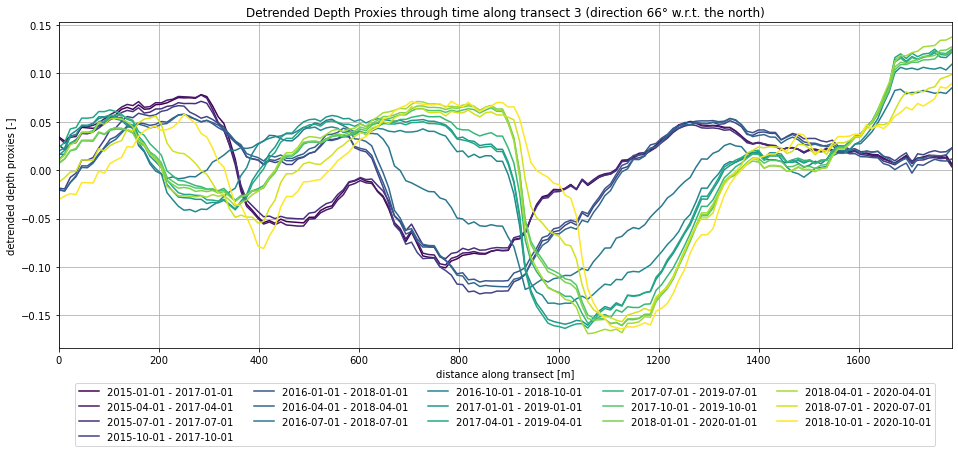

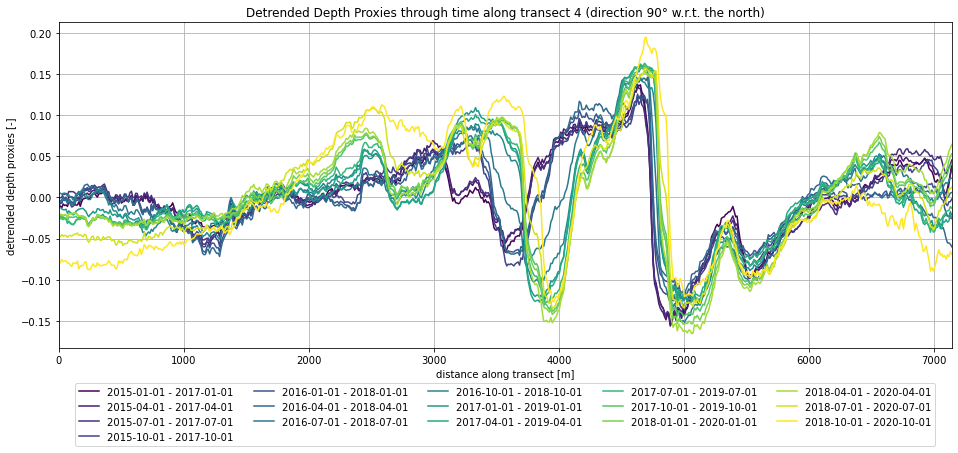

In [9]:
# plot elevations along drawn / loaded transect(s)
detr_zs = []
for idv, (xtr, ytr, dtr, dtrc, zgtr, masktr, tr) in enumerate(zip(tx, ty, td, td_corr, tzg, tmask, trs)):
    angle=math.degrees(math.atan2(tr.coords.xy[0][1] - tr.coords.xy[0][0], 
                                  tr.coords.xy[1][1] - tr.coords.xy[1][0])) # w.r.t degrees north
    
    plt.figure(figsize=(16,6))
    plt.title('Detrended Depth Proxies through time along transect %s (direction %s\xb0 w.r.t. the north)'%(idv+1, 
                                                                                                            int(angle)))
    
    colors = cm.viridis(np.linspace(0, 1, len(zgtr)))
    det_z = []
    for idx, (xs, ys, ds, dsc, zgs, masks, name, col) in enumerate(zip(xtr, ytr, dtr, dtrc, zgtr, masktr, 
                                                                       tile_names, colors)):
        
        # detrending and plotting
        masked = ~np.isnan(ds) & ~np.isnan(zgs)
        result = stats.linregress(ds[masked], zgs[masked])
        trend = result.intercept + result.slope*ds
        detrended = [zgs[j]-trend[j] for j in range(0, len(ds))]
        det_z.append(detrended)
        #RMSE = np.sqrt(np.nanmean(result.rvalue**2)) # root of the mean squared residual of the detrended fit
        #Rsq = result.rvalue**2 # R-squared residual of the detrended fit
        
        # plot by taking out the trend (bias, linear regression)
        plt.plot(dsc, detrended, color=col, label='%s - %s'%(name.split('.')[0].split('_')[-2], 
                                                            name.split('.')[0].split('_')[-1]))
    
    # show what is land
    for idx, i in enumerate(dtrc[0][np.all(masktr, axis=0)]): # lengths where there is always land throughout the composites
        if idx == 0: plt.axvline(i, color='goldenrod', alpha=0.3, label='always land (verticals)')
        else: plt.axvline(i, color='goldenrod', alpha=0.3)
            
    # plot characteristics
    plt.xlim(dtrc[0][0], dtrc[0][-1]);
    plt.xlabel('distance along transect [m]')
    plt.ylabel('detrended depth proxies [-]')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
    plt.grid()
    
    # save figure
    plt.savefig(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects/figs/transect_%s.png'%(idv+1)), 
                bbox_inches='tight')
    
    # appending detrended values
    detr_zs.append(det_z)

In [10]:
# required functions to calculate cross-correlation in next cell

# function to find nearest index
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# function to get 1D cross correlation (returning max corr and the lag (in x-direction))
def cross_corr(y1, y2):
    """Calculates the cross correlation and lags without normalization.

    The definition of the discrete cross-correlation is in:
    https://www.mathworks.com/help/matlab/ref/xcorr.html

    Returns:
      max_corr: Maximum correlation without normalization.
      lag: The lag in terms of the index.
    """
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = np.correlate(y1, y2, mode='same')
    # The unbiased sample size is N - lag.
    unbiased_sample_size = np.correlate(
        np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    lag = argmax_corr - shift # index
    return max_corr, lag

Overall total migration (direction 90° w.r.t. the north): 404 m and 107.73333333333333 m/yr


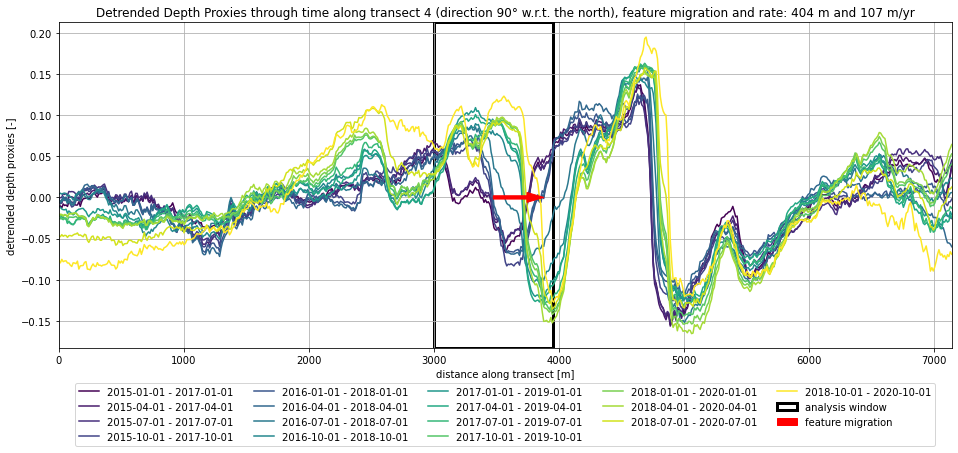

In [14]:
# calculate migration rate vector(s) for interesting areas along drawn / loaded transect(s)
# DISCLAIMER: always check the derived migration rate visually, 1D cross-correlation is just a statistics method and depends on
# your input parameters 'wnd' and 'interp'.

# specify analysis parameters by looking at transect plots
tr_sel = 4 # transect number for analysis
wnd = [3000, 3950] #[4600, 5000] #[3000, 3950] #[5000, 5550] # [m]
interp = 2 # specify interpolation resolution [m]

# calculate the year-to-year 1D cross-correlation
detr_zsfsl = []
detr_zsnsl = []
ctc_mr = []
for idx, (i, j) in enumerate(zip(detr_zs[tr_sel-1], tile_names)):
    if idx+1 == len(detr_zs[tr_sel-1]): break

    ffs = interpolate.interp1d(td_corr[tr_sel-1][idx], detr_zs[tr_sel-1][idx]) # interp first step
    fns = interpolate.interp1d(td_corr[tr_sel-1][idx+1], detr_zs[tr_sel-1][idx+1]) # interp next step
    
    td_corrfs = np.arange(td_corr[tr_sel-1][idx][0], td_corr[tr_sel-1][idx][-1], interp) # 1 m 
    td_corrns = np.arange(td_corr[tr_sel-1][idx+1][0], td_corr[tr_sel-1][idx+1][-1], interp) # 1 m 
    
    detr_zsfs = ffs(td_corrfs) # calculate new, interpolated y's
    detr_zsns = fns(td_corrns) # calculate new, interpolated y's
    detr_zsfsl.append(detr_zsfs), detr_zsnsl.append(detr_zsns)
    
    # find new windows
    xind_wsn = find_nearest(td_corrfs, wnd[0])
    xind_wen = find_nearest(td_corrfs, wnd[1])
    
    # 1D cross-correlation
    corr, lag = cross_corr(detr_zsns[xind_wsn:xind_wen], detr_zsfs[xind_wsn:xind_wen])
    ctc_mr.append(lag*interp)
    
    # time step
    datest = datetime.datetime.strptime(tile_times[idx].split(' - ')[0], "%Y-%m-%d")
    dateed = datetime.datetime.strptime(tile_times[idx+1].split(' - ')[0], "%Y-%m-%d")
    diff_date = relativedelta(dateed, datest)
    diff_date_fl = diff_date.years+diff_date.months/12

    # print statistics (migration distance and rate)
    #print('Composite to composite migration distance and rate: %s m and %s m/yr'%(lag*interp, (lag*interp)/diff_date_fl)) 
    
    # indicative figures for year to year migration 
    #plt.figure(figsize=(16,9))
    # displaced first timestep (achieved by adding +(interp*lag))
    #plt.plot(td_corrfs+(interp*lag), detr_zsfs, 'bo-', label='%s - %s'%(tile_names[idx].split('.')[0].split('_')[-2], 
    #                                                       tile_names[idx].split('.')[0].split('_')[-1]))
    # next timestep
    #plt.plot(td_corrns, detr_zsns, 'ro-', label='%s - %s'%(tile_names[idx+1].split('.')[0].split('_')[-2], 
    #                                                       tile_names[idx+1].split('.')[0].split('_')[-1])) 
    #plt.grid()
    #plt.legend()
    #plt.xlim(wnd[0], wnd[1])
    #plt.show()

# calculate the total 1D cross-correlation (i.e. last - first timestep)
corr, lag = cross_corr(detr_zsnsl[-1][xind_wsn:xind_wen], detr_zsfsl[0][xind_wsn:xind_wen])

# time step
datest = datetime.datetime.strptime(tile_times[0].split(' - ')[0], "%Y-%m-%d")
dateed = datetime.datetime.strptime(tile_times[-1].split(' - ')[0], "%Y-%m-%d")
diff_date = relativedelta(dateed, datest)
diff_date_fl = diff_date.years+diff_date.months/12

# direction
angle=math.degrees(math.atan2(trs[tr_sel-1].coords.xy[0][1] - trs[tr_sel-1].coords.xy[0][0], 
                              trs[tr_sel-1].coords.xy[1][1] - trs[tr_sel-1].coords.xy[1][0])) # w.r.t degrees north

# print statistics (migration distance and rate)
#if np.sum(ctc_mr) >= 0: # direction of drawn transect
#    print('Composite to composite summed total migration and rate (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle), np.sum(ctc_mr), np.sum(ctc_mr)/diff_date_fl))
#elif np.sum(ctc_mr) < 0: # opposite direction of drawn transect
#    print('Composite to composite summed total migration and rate (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle)+180, np.sum(ctc_mr), np.sum(ctc_mr)/diff_date_fl))
if lag*interp >= 0: # direction of drawn transect
    print('Overall total migration (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle), lag*interp, lag*interp/diff_date_fl))
elif lag*interp < 0: # opposite direction of drawn transect
    print('Overall total migration (direction %s\xb0 w.r.t. the north): %s m and %s m/yr'%(int(angle)+180, lag*interp, lag*interp/diff_date_fl))

# overview plot
plt.figure(figsize=(16,6))
# note, migration statistics in title are based on overall total migration and not on summed composite to composite statistics
plt.title('Detrended Depth Proxies through time along transect %s (direction %s\xb0 w.r.t. the north), feature migration and rate: %s m and %s m/yr'%(tr_sel, int(angle), int(lag*interp), int(lag*interp/diff_date_fl)))

colors = cm.viridis(np.linspace(0, 1, len(tzg[tr_sel-1])))
for idx, (xs, ys, ds, dsc, zgs, masks, name, col) in enumerate(zip(tx[tr_sel-1], ty[tr_sel-1], td[tr_sel-1], td_corr[tr_sel-1], 
                                                                   tzg[tr_sel-1], tmask[tr_sel-1], tile_times, colors)):
    
    # detrending and plotting
    masked = ~np.isnan(ds) & ~np.isnan(zgs)
    result = stats.linregress(ds[masked], zgs[masked])
    trend = result.intercept + result.slope*ds
    detrended = [zgs[j]-trend[j] for j in range(0, len(ds))]
    #RMSE = np.sqrt(np.nanmean(result.rvalue**2)) # root of the mean squared residual of the detrended fit
    #Rsq = result.rvalue**2 # R-squared residual of the detrended fit
    
    # plot by taking out the trend (bias, linear regression)
    plt.plot(dsc, detrended, color=col, label='%s - %s'%(name.split(' - ')[0], name.split(' - ')[-1]))

# show what is land
for idx, i in enumerate(dtrc[0][np.all(masktr, axis=0)]): # lengths where there is always land throughout the composites
    if idx == 0: plt.axvline(i, color='goldenrod', alpha=0.3, label='always land (verticals)')
    else: plt.axvline(i, color='goldenrod', alpha=0.3)
        
# analysis window
plt.axvspan(wnd[0], wnd[1], fill=False, color='k', linewidth=3, label='analysis window')
plt.arrow(wnd[0]+(wnd[1]-wnd[0])/2, 0, lag*interp, 0, color='r', zorder=5, width=0.004, head_length=(1/3)*lag*interp, 
          length_includes_head=True, label='feature migration') # direction changes automatically with its lag sign
        
# plot characteristics
plt.xlim(dtrc[0][0], dtrc[0][-1]);
plt.xlabel('distance along transect [m]')
plt.ylabel('detrended depth proxies [-]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=5)
plt.grid()

# save figure
plt.savefig(os.path.join(os.getcwd(),'RWS_AOI', project_name+'_transects/figs/transect_%s_analysis_window_%s_%s.png'%(idv+1, wnd[0], wnd[1])), 
            bbox_inches='tight')